<center><h1>Mapping the emotional face. How individual face parts contribute to successful emotion recognition.</h1></center>

# 8. Interactive plotting of action unit weights

This notebook aggregates the tiles in accordance to the Ekman Action Units (AUs) they fall into.  
Unlike notebook 4, here also mistakes are being considered. I.e. while previously the weights were given only for correct responses, now we can also visualize which areas in the face drive incorrect labeling, like seeing the eyes in a fearful face but thinking it represents surprise.  
Due to the richness of the data that emerge (14 faces x 7 response types), this is done interactively, so figures are generated on the fly.

### importing the basic modules and files

In [1]:
from myBasics import *
%matplotlib inline

In [2]:
logList = getFile('../rawTables/','pand*.csv')

## Assign AUs to tiles

Get a list of all possible tile coordinates

In [3]:
def makeCoordinates(xNum,yNum,squareSize):
    myArray = []
    xDim=xNum*squareSize
    yDim=yNum*squareSize
    for x in np.arange(0,xDim,squareSize):
        for y in np.arange(0,yDim,squareSize):
            myArray.append( (x,y) )
    
    return myArray

In [4]:
thisCoord = makeCoordinates(6,8,50)
print thisCoord
print "\nNumber of Coordinates:", len(makeCoordinates(6,8,50))

[(0, 0), (0, 50), (0, 100), (0, 150), (0, 200), (0, 250), (0, 300), (0, 350), (50, 0), (50, 50), (50, 100), (50, 150), (50, 200), (50, 250), (50, 300), (50, 350), (100, 0), (100, 50), (100, 100), (100, 150), (100, 200), (100, 250), (100, 300), (100, 350), (150, 0), (150, 50), (150, 100), (150, 150), (150, 200), (150, 250), (150, 300), (150, 350), (200, 0), (200, 50), (200, 100), (200, 150), (200, 200), (200, 250), (200, 300), (200, 350), (250, 0), (250, 50), (250, 100), (250, 150), (250, 200), (250, 250), (250, 300), (250, 350)]

Number of Coordinates: 48


### Small script  to get the rgb color of each mask

In [5]:
def getColor(imName):

    im = Image.open(imName)
    # we loop through all pixels
    for y in xrange(im.size[1]):
        for x in xrange(im.size[0]):
            # we get the RGB+alpha values of each pixel
            r,g,b,a =  im.load()[x, y]
            # we are only intereset in colored pixels
            if (r,g,b) != (0,0,0):
                # store the present color for later re-use
                thisColor = (r,g,b)
                # and stop here
                break
    return thisColor

### Determining for each tile, whether it contains some colored pixels

We loop through the image, tile by tile. For this, we use For each tile, count the occurence of each color on a pixel-by-pixel basis. We use the thisCoord list of all tile coordinates (where each coordinate tuple denotes the upper left corner of the 50x50 tile).  
The first output is a dictionary, with tile coordinates as keys and number of colored pixels as values.  
The second output is the RGB value of the color used for that AU. Since each image contains only one AU and should have only one color, this works by taking the color of any non-black (0,0,0) pixel.


In [6]:
def getTiles(im,thisCoord=thisCoord,squareSize=50):
    
    # resize the image, if it is not exactly 300x400 (as it was presented in the experiment),
    # this should not be necessary in general
    im = im.resize((300,400))
    
    # the dictionary where we write the occurence of colored pixels for each tile
    thisCut = {}

    # we loop through the coordinate list
    for coord in thisCoord:
        # we get the (h)orizontal and (v)ertical coordinates from the tuple
        h,v = coord

        # we cut out the tile
        cut = im.crop((h,v,h+squareSize,v+squareSize))
        pixdata=cut.load()

        # we loop through all pixels of that tile
        for y in xrange(cut.size[1]):
            for x in xrange(cut.size[0]):
                # we get the RGB+alpha values of each pixel
                r,g,b,a =  pixdata[x, y]
                # we are only intereset in colored pixels
                if (r,g,b) != (0,0,0):
                    # store the present color for later re-use
                    thisColor = (r,g,b)
                    # count the occurence of colored pixels for that tile/coordinate pair
                    try:
                        thisCut[coord]+=1
                    except:
                        thisCut[coord]=1

        # if the tile remained empty, assign zero
        if coord not in thisCut:
            thisCut[coord] = 0
    
    # return the dict and a tuple with RGB values of that Action Unit
    return thisCut,thisColor

### get tiles for all AUs

In [7]:
def makeAUTable(myPicList):
    
    # get number of colored pixels in each tile for all AUs of a face
    d = {}
    for pic in myPicList:
        d[pic] = getTiles( Image.open(pic) )
        
    # transform this into a dataframe
    bigDf = pd.DataFrame()
    for key in d:
        thisDf = pd.DataFrame(d[key][0],index=[key]).T
        bigDf = pd.concat([bigDf,thisDf],axis=1)

    return bigDf

Binarize in a way that multiple AUs can belong to a tile, but only if they pass a defined cutoff

In [8]:
def makeBinAUs(bigDf,cutOff=25):
         
    return (bigDf>cutOff).astype(int)

### visualize the result

In [9]:
def showTiles(bgIm,d,squareSize=50):

    imDict = {}

    # loop through the action units
    for au in d:
        
        # get the face image as a background to visualize on
        imOut = Image.open(bgIm)
        imOut = imOut.resize((300,400))
    
        # loop through the tile coordinates
        for coords in d[au]:

            h,v = coords
            if d[au][coords] == 1:
                thisColor = getColor(au)
            else:
                thisColor = 0

            faceTile = imOut.crop((h,v,h+squareSize,v+squareSize))

            if thisColor == 0:

                imOut.paste(faceTile, (h,v))

            else:
                pixdata=faceTile.load()

                # change its color by looping through all the pixels of the cutout
                for y in xrange(faceTile.size[1]):
                    for x in xrange(faceTile.size[0]):
                        pixdata[x, y] = thisColor
                    # paste the fully colored tile onto the background image
                    imOut.paste(faceTile, (h,v))
                    
        imDict[au] = imOut
        
    return imDict

In [10]:
myPicList = getFile('../auLabels/','f_ang*.png')

In [11]:
d = makeBinAUs( makeAUTable(myPicList) ).to_dict()
imDict = showTiles(picList[0][2],d)

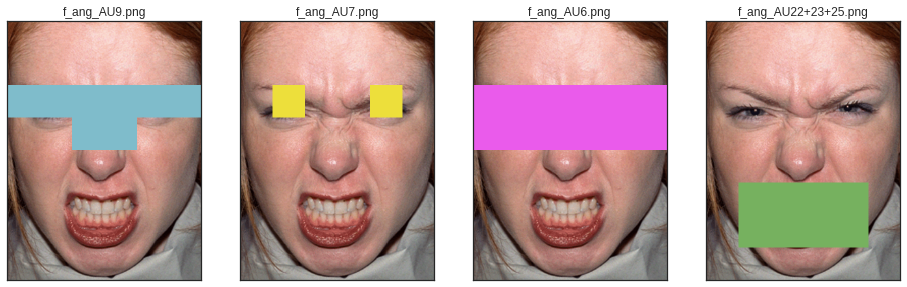

In [12]:
fig = plt.figure(figsize=(16,6))
for i,im in enumerate(imDict):
    ax = plt.subplot( 1, len(imDict.keys()), i+1 )
    ax.set_title(im[im.rfind('/')+1:],fontsize=12)
    ax = plt.imshow(imDict[im])
    plt.xticks([]); plt.yticks([])
plt.show()

### Get all the pictures and their respective AU lists

Here we define a dictionary *picDict*, wich is used to store the filenames of the original image and the AU images for each face.

In [13]:
def makePicDict(picList):
    
    picDict = {}
    for i,ident in enumerate(picList):
        for e,emo in enumerate(picList[i]):
            thisPic = picList[i][e]

            thisName = thisPic[thisPic.find('_')-1:thisPic.rfind('_')]

            myPicList = getFile('../auLabels/',thisName+'*.png')

            picDict[thisName] = {'auList':myPicList,
                                 'picFile':thisPic}
    return picDict

In [14]:
picDict = makePicDict(picList)

In [15]:
picDict

{'f_ang': {'auList': ['../auLabels/f_ang_AU22+23+25.png',
   '../auLabels/f_ang_AU6.png',
   '../auLabels/f_ang_AU7.png',
   '../auLabels/f_ang_AU9.png'],
  'picFile': '../experiment/app/static/img/f_ang_cut.png'},
 'f_dis': {'auList': ['../auLabels/f_dis_AU10+16+19+25+26.png',
   '../auLabels/f_dis_AU4.png',
   '../auLabels/f_dis_AU6.png',
   '../auLabels/f_dis_AU9.png'],
  'picFile': '../experiment/app/static/img/f_dis_cut.png'},
 'f_fea': {'auList': ['../auLabels/f_fea_AU1.png',
   '../auLabels/f_fea_AU2.png',
   '../auLabels/f_fea_AU20+25.png',
   '../auLabels/f_fea_AU5.png'],
  'picFile': '../experiment/app/static/img/f_fea_cut.png'},
 'f_hap': {'auList': ['../auLabels/f_hap_AU12.png',
   '../auLabels/f_hap_AU25.png',
   '../auLabels/f_hap_AU6.png'],
  'picFile': '../experiment/app/static/img/f_hap_cut.png'},
 'f_ntr': {'auList': ['../auLabels/f_ntr_AU25.png'],
  'picFile': '../experiment/app/static/img/f_ntr_cut.png'},
 'f_sad': {'auList': ['../auLabels/f_sad_AU1+4.png',
   '../a

make a list with face names, which is sorted in a nice way, so we can use it for looping

In [16]:
picSort = []
for entry in picList:
    for subentry in entry:
        picSort.append(subentry[subentry.rfind('/')+1:subentry.rfind('_')])
print picSort

['f_hap', 'f_sad', 'f_ang', 'f_fea', 'f_dis', 'f_sup', 'f_ntr', 'm_hap', 'm_sad', 'm_ang', 'm_fea', 'm_dis', 'm_sup', 'm_ntr']


### show all the tile-assignments of action units

In [17]:
picDict[picSort[0]]

{'auList': ['../auLabels/f_hap_AU12.png',
  '../auLabels/f_hap_AU25.png',
  '../auLabels/f_hap_AU6.png'],
 'picFile': '../experiment/app/static/img/f_hap_cut.png'}

## Derive behavioral metric

These are the acutal behavioral data, which we now want to apply not to single tiles, but to groups of tiles which all belong to the same action unit. The algorithms to derive the values are esentially the same as in the previous notebooks.

In [18]:
df = pd.read_csv(logList[-2],
                 header=0,
                 index_col=[0,1,2]
                )

In [19]:
df.head()

time     cumtime  e  i button  \
ident express id                                                 
0     0       8   2016-03-10 14:14:11   223.38838  0  0    hap   
              14  2016-03-10 14:16:22   353.89436  0  0    hap   
              38  2016-03-10 14:25:14   886.06328  0  0    hap   
              45  2016-03-10 14:28:01  1052.94504  0  0    hap   
              60  2016-03-10 14:33:00  1352.16195  0  0    hap   

                           filename evaluation  stopRT  choiceRT  maskNum  \
ident express id                                                            
0     0       8   img/f_hap_cut.png        HIT    7837     12277        8   
              14  img/f_hap_cut.png        HIT    7182      9014        8   
              38  img/f_hap_cut.png        HIT    5245      7773        6   
              45  img/f_hap_cut.png        HIT    5855      7047        6   
              60  img/f_hap_cut.png        HIT    6383      8055        7   

                                maskList   #  
ident express id                              
0     0       8   11-29-31-37-27-15-5-45   8  
              14  36-5-42-22-30-15-29-13  14  
              38        38-11-21-36-1-41  38  
              45        10-25-22-30-38-0  45  
              60    17-25-22-15-12-35-41  60

In [20]:
def getWeight(df,thisName,identName,expressName,answer,n=16,identDict=identDict,emoDict=emoDict):
    
    d = {}
    
    # code to number
    ident = identReverse[identName]
    express = emoReverse[expressName]
    
    # get the current condition (face identity and emotion expression)
    thisCondDf = df.ix[ident].ix[express]
    # get only the answers as specified
    thisDf = thisCondDf.loc[thisCondDf['button'] == answer]

    # loop through all trials of that condition
    for i in thisDf.index:
            
        # we get the list of revealed tiles
        maskList = thisDf.ix[i]['maskList']
        thisSplit = maskList.split('-')
        # if the current trial is short enough
        if len(thisSplit) <= n:
                    
            # we apply the above formula to get a weight for the importance of that trial
                    
            ####
            thisFormula = 1. - (len(thisSplit)/float(n) ) 
            ####
                    
            # now each tile of that trial gets that weight assigned, because it was
            # part of this trial
            for num in thisSplit:
                # we try to append, if this does not work, we create the entry
                try:
                    d[num].append(thisFormula)
                except:
                    d[num] = [thisFormula]
                            
            # everyone else not present gets a zero
            # this works by having a list of all possible tile indices (0-47)
            # and removing indeces of all trial that were actually present
            unassigned = range(48)
            for num in thisSplit: unassigned.remove( int(num) )
            # now each tile that was not in the trial gets a zero for having been absent
            for num in unassigned:
                try:
                    d[str(num)].append(0)
                except:
                    d[str(num)] = [0]
    
    # note that if a trial contained an incorrect answer or was not short enough, it is
    # entierly ignored. This might not be desireable, however. E.g. one might argue that
    # if a tile is often part of an incorrect trial, it should get a negative weight
    # so there are certainly many possibilities to make the formula more sophisticated
    
    #average over all trials for each tile 
    outDf = pd.DataFrame( pd.DataFrame( d ).mean() )
    # make the index nice and restructure
    outDf.index = [int(x) for x in outDf.index]
    outDf = outDf.sort_index()
    outDf = outDf.T
    outDf.index = [[thisName],[identDict[ident]],[emoDict[emoReverse[answer]]]]
    outDf = outDf.sortlevel()
    # return a row with all values of the current expression
    return outDf

In [21]:
getWeight(df,'p001','f','hap','hap')

0         1        2        3   4       5   6         7   \
p001 f hap  0.058594  0.097656  0.03125  0.09375   0  0.0625   0  0.128906   

                  8         9         10       11        12        13  \
p001 f hap  0.019531  0.042969  0.089844  0.15625  0.113281  0.144531   

                  14        15       16        17  18       19  20        21  \
p001 f hap  0.097656  0.144531  0.03125  0.074219   0  0.03125   0  0.207031   

                  22  23  24        25        26       27        28        29  \
p001 f hap  0.105469   0   0  0.105469  0.035156  0.03125  0.039062  0.113281   

                  30       31        32        33        34     35        36  \
p001 f hap  0.109375  0.03125  0.097656  0.078125  0.046875  0.125  0.132812   

                  37        38  39        40        41        42       43  \
p001 f hap  0.070312  0.078125   0  0.042969  0.121094  0.109375  0.15625   

                  44        45  46        47  
p001 f hap  0.105469  0.113281   0  0.035156

In [22]:
def makePSC(bigWeight):

    # normalize
    byMean = bigWeight.T/bigWeight.T.mean()
    scaledDf = (( ( byMean ).T )*100) -100 # that's the PSC formula
    
    return scaledDf

In [23]:
makePSC( getWeight(df,'p001','f','hap','hap') )

0         1          2          3    4          5    6   \
p001 f hap -19.821826  33.63029 -57.238307  28.285078 -100 -14.476615 -100   

                   7          8          9          10          11         12  \
p001 f hap  76.391982 -73.273942 -41.202673  22.939866  113.808463  55.011136   

                   13        14         15         16       17   18  \
p001 f hap  97.772829  33.63029  97.772829 -57.238307  1.55902 -100   

                   19   20          21         22   23   24         25  \
p001 f hap -57.238307 -100  183.296214  44.320713 -100 -100  44.320713   

                   26         27         28         29         30         31  \
p001 f hap -51.893096 -57.238307 -46.547884  55.011136  49.665924 -57.238307   

                  32        33         34         35         36        37  \
p001 f hap  33.63029  6.904232 -35.857461  71.046771  81.737194 -3.786192   

                  38   39         40         41         42          43  \
p001 f hap  6.904232 -100 -41.202673  65.701559  49.665924  113.808463   

                   44         45   46         47  
p001 f hap  44.320713  55.011136 -100 -51.893096

In [24]:
def getParticipantWeights(df,pName,emo):
    bigDf = pd.DataFrame()
    for ident in identReverse.keys():
        for answer in emoReverse.keys():
            thisDf = makePSC( getWeight(df,pName,ident,emo,answer) )
            bigDf = pd.concat([bigDf,thisDf])
    return bigDf.fillna(0)

In [25]:
getParticipantWeights(df,'p001','hap')

0          1          2           3           4   \
p001 m ang    0.000000   0.000000   0.000000    0.000000    0.000000   
       fea    0.000000   0.000000   0.000000    0.000000    0.000000   
       ntr    0.000000   0.000000   0.000000    0.000000    0.000000   
       sad    0.000000   0.000000   0.000000    0.000000    0.000000   
       sup    0.000000   0.000000   0.000000    0.000000    0.000000   
       hap -100.000000 -22.291407  91.282690 -100.000000  -22.291407   
       dis    0.000000   0.000000   0.000000    0.000000    0.000000   
     f ang    0.000000   0.000000   0.000000    0.000000    0.000000   
       fea    0.000000   0.000000   0.000000    0.000000    0.000000   
       ntr    0.000000   0.000000   0.000000    0.000000    0.000000   
       sad    0.000000   0.000000   0.000000    0.000000    0.000000   
       sup    0.000000   0.000000   0.000000    0.000000    0.000000   
       hap  -19.821826  33.630290 -57.238307   28.285078 -100.000000   
       dis    0.000000   0.000000   0.000000    0.000000    0.000000   

                    5           6          7          8          9   \
p001 m ang    0.000000    0.000000   0.000000   0.000000   0.000000   
       fea    0.000000    0.000000   0.000000   0.000000   0.000000   
       ntr    0.000000    0.000000   0.000000   0.000000   0.000000   
       sad    0.000000    0.000000   0.000000   0.000000   0.000000   
       sup    0.000000    0.000000   0.000000   0.000000   0.000000   
       hap -100.000000  -16.313823 -22.291407  37.484433 -34.246575   
       dis    0.000000    0.000000   0.000000   0.000000   0.000000   
     f ang    0.000000    0.000000   0.000000   0.000000   0.000000   
       fea    0.000000    0.000000   0.000000   0.000000   0.000000   
       ntr    0.000000    0.000000   0.000000   0.000000   0.000000   
       sad    0.000000    0.000000   0.000000   0.000000   0.000000   
       sup    0.000000    0.000000   0.000000   0.000000   0.000000   
       hap  -14.476615 -100.000000  76.391982 -73.273942 -41.202673   
       dis    0.000000    0.000000   0.000000   0.000000   0.000000   

                   10          11         12          13         14  \
p001 m ang   0.000000    0.000000   0.000000    0.000000   0.000000   
       fea   0.000000    0.000000   0.000000    0.000000   0.000000   
       ntr   0.000000    0.000000   0.000000    0.000000   0.000000   
       sad   0.000000    0.000000   0.000000    0.000000   0.000000   
       sup   0.000000    0.000000   0.000000    0.000000   0.000000   
       hap  79.327522  -64.134496 -22.291407  186.924035  55.417186   
       dis   0.000000    0.000000   0.000000    0.000000   0.000000   
     f ang   0.000000    0.000000   0.000000    0.000000   0.000000   
       fea   0.000000    0.000000   0.000000    0.000000   0.000000   
       ntr   0.000000    0.000000   0.000000    0.000000   0.000000   
       sad   0.000000    0.000000   0.000000    0.000000   0.000000   
       sup   0.000000    0.000000   0.000000    0.000000   0.000000   
       hap  22.939866  113.808463  55.011136   97.772829  33.630290   
       dis   0.000000    0.000000   0.000000    0.000000   0.000000   

                   15          16         17   18         19          20  \
p001 m ang   0.000000    0.000000   0.000000    0   0.000000    0.000000   
       fea   0.000000    0.000000   0.000000    0   0.000000    0.000000   
       ntr   0.000000    0.000000   0.000000    0   0.000000    0.000000   
       sad   0.000000    0.000000   0.000000    0   0.000000    0.000000   
       sup   0.000000    0.000000   0.000000    0   0.000000    0.000000   
       hap -28.268991  180.946451 -58.156912 -100  79.327522   49.439601   
       dis   0.000000    0.000000   0.000000    0   0.000000    0.000000   
     f ang   0.000000    0.000000   0.000000    0   0.000000    0.000000   
       fea   0.000000    0.000000   0.000000    0   0.000000    0.000000   
       ntr   0.000000    0.000000   0.000000   

## Combining The AU assigments and the tile metrics

In [26]:
def writeMetric(thisBig,p,ident,express,answer,picDict=picDict,thisCoord=thisCoord):
    
    facePic = ident+'_'+express
    auList = picDict[facePic]['auList']
    
    metricDf = thisBig.ix[p].ix[ident].ix[answer]

    # transforming the coordinates to indices from 0 to 47
    cCodes = {}
    for c,coord in enumerate(thisCoord):
        cCodes[ c ] = coord

    # dict to write to
    auDict = {float(np.nan):[]}
    
    # tracker for tiles belonging to no au
    notNan = []
    
    for au in auList:

        auDict[au] = []
        
        # mapping of coordinates to AUs
        d = makeBinAUs( makeAUTable(auList) ).to_dict()
        
        # looping through the metrics
        for key in metricDf.to_dict():
            thisCoord = d[au][cCodes[int(key)]]
            # get the metric
            thisMetric = metricDf.to_dict()[key]
            if d[au][tuple(cCodes[int(key)])] == 1:
                # adding value to 
                auDict[au].append( thisMetric)

                # keep track that this is not a nan
                notNan.append(key)

    # do that for the remaining nans
    for key in metricDf.to_dict():
        if key not in notNan:
            thisCoord = d[au][cCodes[int(key)]]
            # get the metric
            thisMetric = metricDf.to_dict()[key]
            # adding value to 
            auDict[float(np.nan)].append( thisMetric)

    # transform to df
    auDf = pd.DataFrame(index=[p])
    
    for entry in auDict:
        auDf[entry] = np.mean(auDict[entry])

    # cleaning up columns names
    cleanCols = []
    for e in auDf.columns:
        if type(e) == str:
            cleanCols.append(e[e.rfind('_')+1:e.rfind('.')] )
        else:
            cleanCols.append(e)

    auDf.columns = cleanCols
    return auDf

In [27]:
def writeAllMetrics(p,ident,express):
    
    df = pd.read_csv(p,
                     header=0,
                     index_col=[0,1,2]
                    )
    pName = 'p'+ ('00'+ p[p.find('0')+1:p.rfind('.')])[-3:]
    thisBig = getParticipantWeights(df,pName,express)
    bigDf = pd.DataFrame()
    for answer in emoReverse.keys():
        thisDf = writeMetric(thisBig,pName,ident,express,answer)
        thisDf.columns = [[answer]*len(thisDf.columns),thisDf.columns]
        bigDf = pd.concat([bigDf,thisDf],axis=1)
    return bigDf

In [28]:
writeAllMetrics(logList[-1],'f','hap')

ang               fea                      ntr                      sad  \
     NaN AU12 AU25 AU6 NaN AU12 AU25 AU6        NaN AU12 AU25        AU6 NaN   
p096   0    0    0   0   0    0    0   0  20.376176 -100 -100  30.909091   0   

                   sup                      hap                        \
     AU12 AU25 AU6 NaN AU12 AU25 AU6        NaN        AU12      AU25   
p096    0    0   0   0    0    0   0 -26.812104  104.081633  69.09621   

                dis                
            AU6 NaN AU12 AU25 AU6  
p096  20.816327   0    0    0   0

In [29]:
def writeAllParticipants(logList,ident,express):
    bigDf = pd.DataFrame()
    for logFile in logList:
        thisDf = writeAllMetrics(logFile,ident,express)
        bigDf = pd.concat([bigDf,thisDf])
    
    return bigDf

### This will take brutally long, so we save this once as csv's and later load from those

In [30]:
def realBig(logList):
    for ident in identReverse.keys():
        for emo in emoReverse.keys():
            print "working on",ident,emo,'...'
            bigAU = writeAllParticipants(logList,ident,emo)
            bigAU.to_csv('../outputs/actionUnits_'+ident+'_'+emo+'.csv')

In [31]:
#### realBig(logList)

### Taking the nan (no Action Unit) as baseline

In [32]:
bigAU = pd.read_csv('../outputs/actionUnits_m_ang.csv',
                    index_col=[0],header=[0,1])
bigAU.head()

ang                                          fea             \
            nan    AU25+29         AU7        AU4        nan    AU25+29   
p001   0.000000   0.000000    0.000000   0.000000  -3.879850  60.486322   
p002  -6.348282  -6.647808   33.663366  37.482320   9.803922  52.380952   
p003 -19.191919  26.984127   85.858586  66.233766  15.508021 -37.662338   
p004 -20.204604  26.708075  173.913043  71.428571   0.000000   0.000000   
p005 -13.459621  14.285714   69.491525  51.089588   0.000000   0.000000   

                                   ntr                                    \
            AU7         AU4        nan    AU25+29         AU7        AU4   
p001    2.12766  -41.641337 -19.327731  46.938776  -14.285714  46.938776   
p002 -100.00000 -100.000000  14.168798 -34.409938 -100.000000 -34.409938   
p003 -100.00000  -37.662338   0.000000   0.000000    0.000000   0.000000   
p004    0.00000    0.000000   0.000000   0.000000    0.000000   0.000000   
p005    0.00000    0.000000   0.000000   0.000000    0.000000   0.000000   

            sad                                     sup                 hap  \
            nan     AU25+29         AU7         AU4 nan AU25+29 AU7 AU4 nan   
p001 -38.423029  104.255319   78.723404   82.370821   0       0   0   0   0   
p002  -8.359133   28.320802   33.333333   12.280702   0       0   0   0   0   
p003   0.000000    0.000000    0.000000    0.000000   0       0   0   0   0   
p004 -19.327731  193.877551 -100.000000 -100.000000   0       0   0   0   0   
p005  19.457014    5.494505 -100.000000 -100.000000   0       0   0   0   0   

                           dis                                    
     AU25+29 AU7 AU4       nan    AU25+29         AU7        AU4  
p001       0   0   0 -9.243697  95.918367  -14.285714 -51.020408  
p002       0   0   0 -5.882353  71.428571    0.000000 -42.857143  
p003       0   0   0 -7.073716  12.839060  112.658228  21.518987  
p004       0   0   0  0.000000   0.000000    0.000000   0.000000  
p005       0   0   0  0.000000   0.000000    0.000000   0.000000

In [33]:
def baselineCorrection(df,cond):
    # select the condition
    thisCorr = df[cond]
    diffDf = pd.DataFrame()

    # for all action units
    for actionUnit in thisCorr.columns:
        # we subtract the baseline
        thisDiff = thisCorr[actionUnit]-thisCorr[u'nan']
        diffDf[actionUnit] = thisDiff
    diffDf = diffDf.drop('nan',axis=1)
    
    # restore the original structure of the multicolumns
    diffDf.columns = [[cond]*len(diffDf.columns),diffDf.columns]
    
    return diffDf

Example:

In [34]:
bigAU['ang'].head()

nan    AU25+29         AU7        AU4
p001   0.000000   0.000000    0.000000   0.000000
p002  -6.348282  -6.647808   33.663366  37.482320
p003 -19.191919  26.984127   85.858586  66.233766
p004 -20.204604  26.708075  173.913043  71.428571
p005 -13.459621  14.285714   69.491525  51.089588

In [35]:
baselineCorrection(bigAU,'ang').head()

ang                       
        AU25+29         AU7        AU4
p001   0.000000    0.000000   0.000000
p002  -0.299526   40.011648  43.830602
p003  46.176046  105.050505  85.425685
p004  46.912678  194.117647  91.633175
p005  27.745335   82.951147  64.549210

In [36]:
def makeBaseline(bigAU):
    baselineDf = pd.DataFrame()
    for face in bigAU.columns.levels[0]:
        thisDf = baselineCorrection(bigAU,face)
        baselineDf = pd.concat([baselineDf,thisDf],axis=1)
    
    return baselineDf

In [37]:
baselineDf = makeBaseline(bigAU)

In [38]:
baselineDf['ang'].head()

AU25+29         AU7        AU4
p001   0.000000    0.000000   0.000000
p002  -0.299526   40.011648  43.830602
p003  46.176046  105.050505  85.425685
p004  46.912678  194.117647  91.633175
p005  27.745335   82.951147  64.549210

## Basic plotting

In [39]:
#http://stackoverflow.com/a/214657
def rgb2hex(rgb):
    return '#%02x%02x%02x' % rgb

In [40]:
def makeActionUnitPlot(ident,emo,ans):
    
    face = ident+'_'+emo
    
    bigAU = pd.read_csv('../outputs/actionUnits_'+face+'.csv',
                    index_col=[0],header=[0,1])
    
    baselineDf = makeBaseline(bigAU)
    
    # select the face condition
    thisDf = baselineDf[ans]
    
    colNames = thisDf.columns
    # get number of participants (with values)
    n = int(thisDf.describe().ix['count'][-1])
    
    # get all metrics into a df which we sort descending
    plotDf = pd.DataFrame()
    plotDf['mean'] = thisDf.mean()
    #print float( thisDf.mean() ), float( thisDf.describe().ix['mean'] )
    plotDf['ci'] = thisDf.std()/np.sqrt(n)*1.96
 
    plotDf['color'] = [rgb2hex(getColor('../auLabels/'+face+'_'+colName+'.png')) for colName in colNames]
    plotDf = plotDf.sort_values(by="mean",ascending=False)
   
    # plot this bar at the correct position and using the correct color
    # this is done in a 
    plt.xticks(np.arange(len(plotDf.index))+0.45,plotDf.index,rotation=45,fontsize=12)
    #plt.ylim(-10,100)
    plt.axhline(0,color='k')
    plt.title(ans,fontsize=20)
    im = plt.bar(range(len(plotDf.index)) ,
            plotDf['mean'],
            yerr=plotDf['ci'],
            color= plotDf['color'],
            ecolor='k')
    
    return im

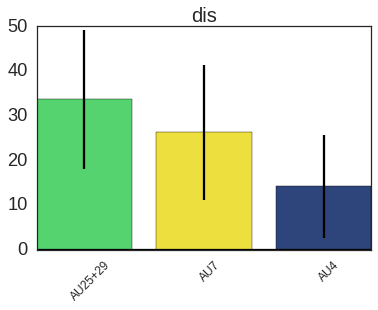

In [41]:
makeActionUnitPlot('m','ang','dis');

## Visualize it all

### get the images with the hand-drawn AUs

In [42]:
myPaintList =  []
for fGender in ['f','m']:
    thisList = []
    for fEmo in myLabels.values()[:-1]:
        thisFace = getFile('../auLabels/auVisualisation/',fGender+'_'+fEmo+'*.png')[-1]
        thisList.append(thisFace)
    myPaintList.append(thisList) 

### plot all confusions and the face that was rated

In [49]:
def makePlot(ident,emo):
    fig = plt.figure(figsize=(16,10))
    
    ax = plt.subplot(2,4,1)
    im=Image.open(myPaintList[identReverse[ident]][emoReverse[emo]],'r')
    ax.imshow(im)
    ax.set_yticks([]); ax.set_xticks([])
    
    count = 2
    for answer in ['hap','sad','ang','fea','dis','sup','ntr']:#emoReverse.keys():
        ax = plt.subplot(2,4,count)
        ax = makeActionUnitPlot(ident,emo,answer);
        plt.ylim(-35,105)
        plt.yticks(range(-20,130,20),[str(x)+'%' for x in range(-20,121,20) ])
        sns.despine()
        count+=1
    plt.tight_layout()
    plt.savefig('../auConfusions/confPlot_'+ident+'_'+emo+'.png',dpi=300)
    return fig

save all to file

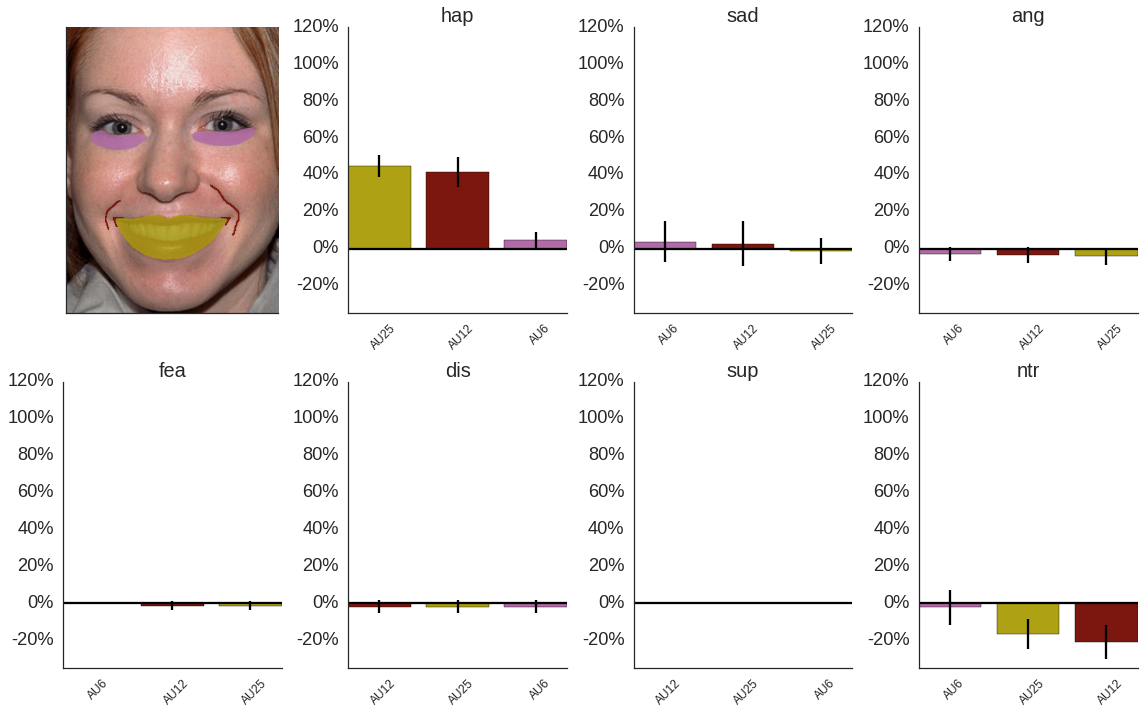

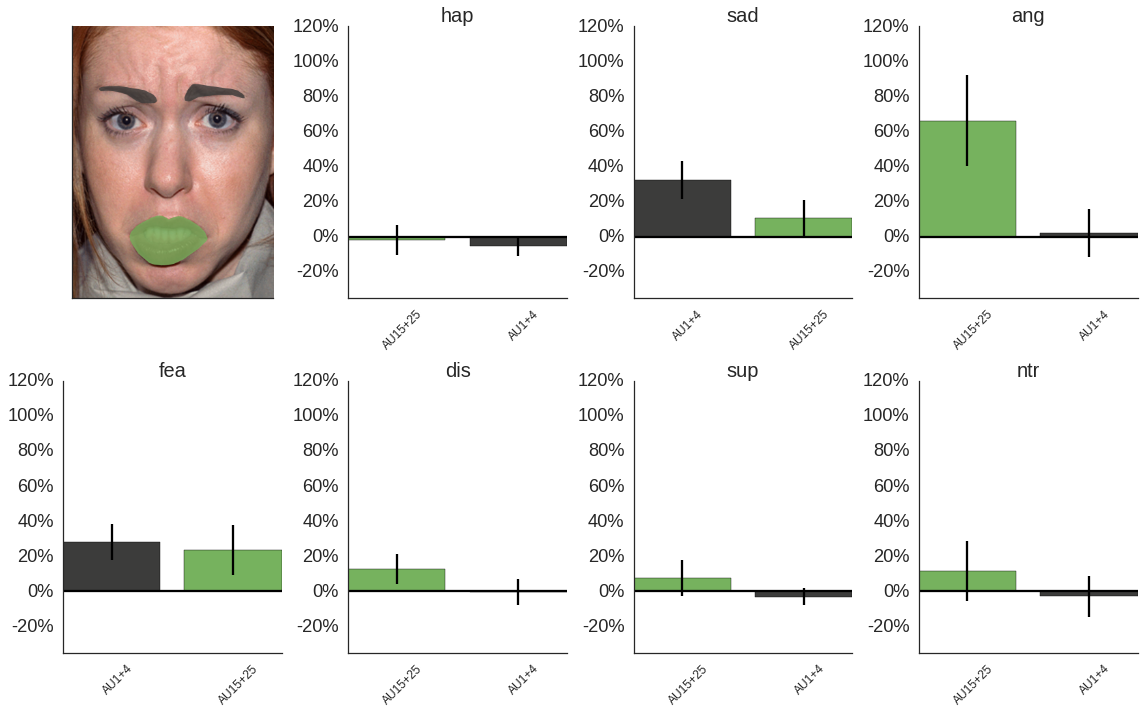

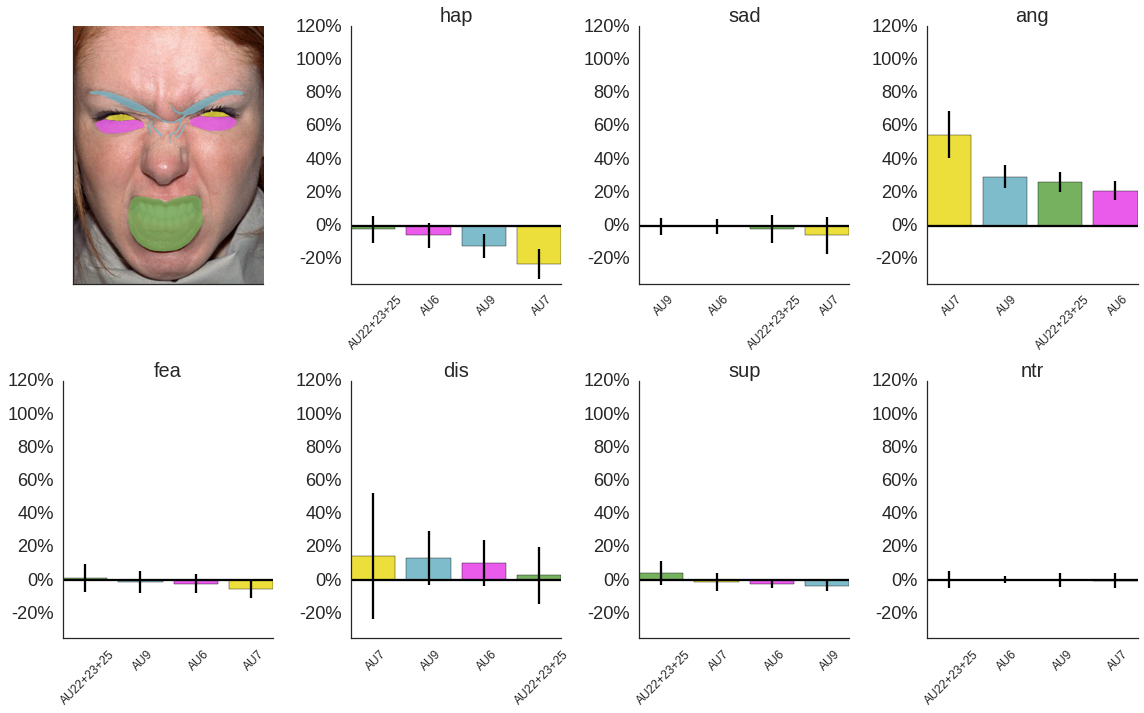

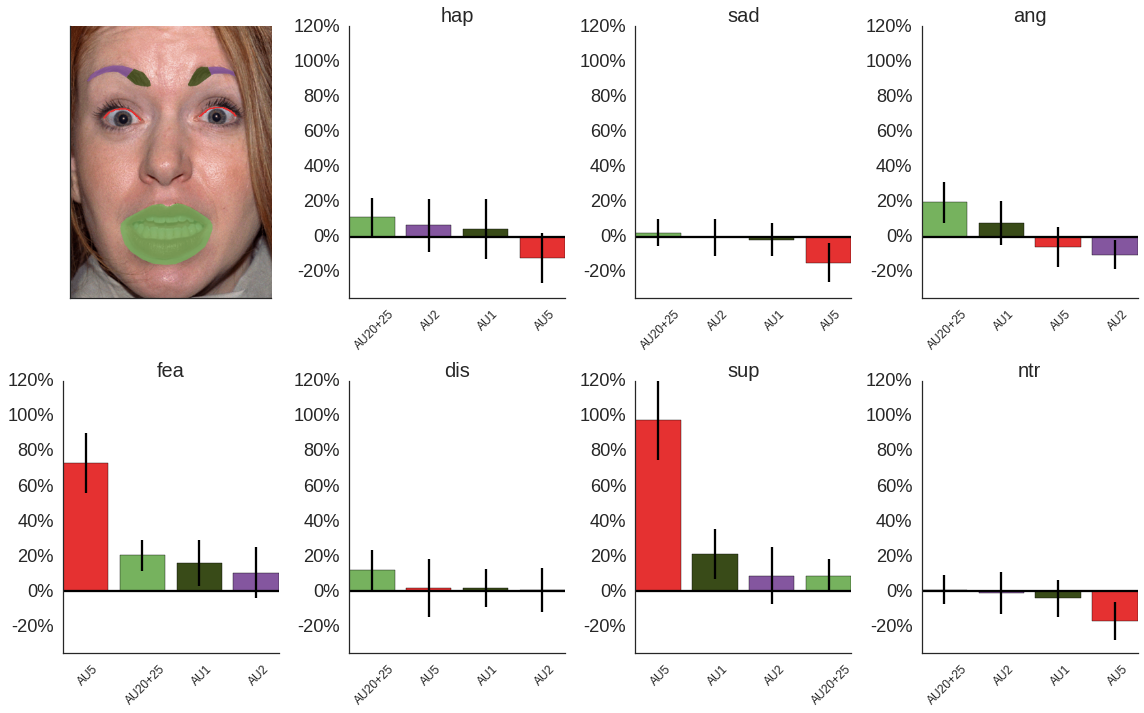

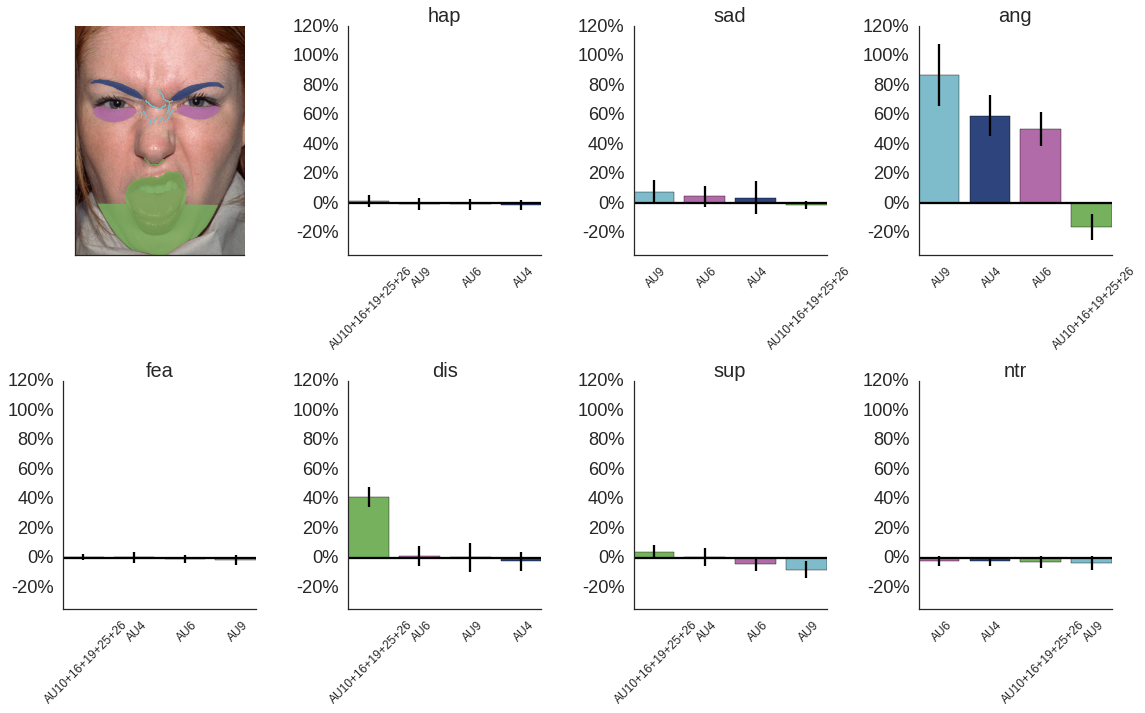

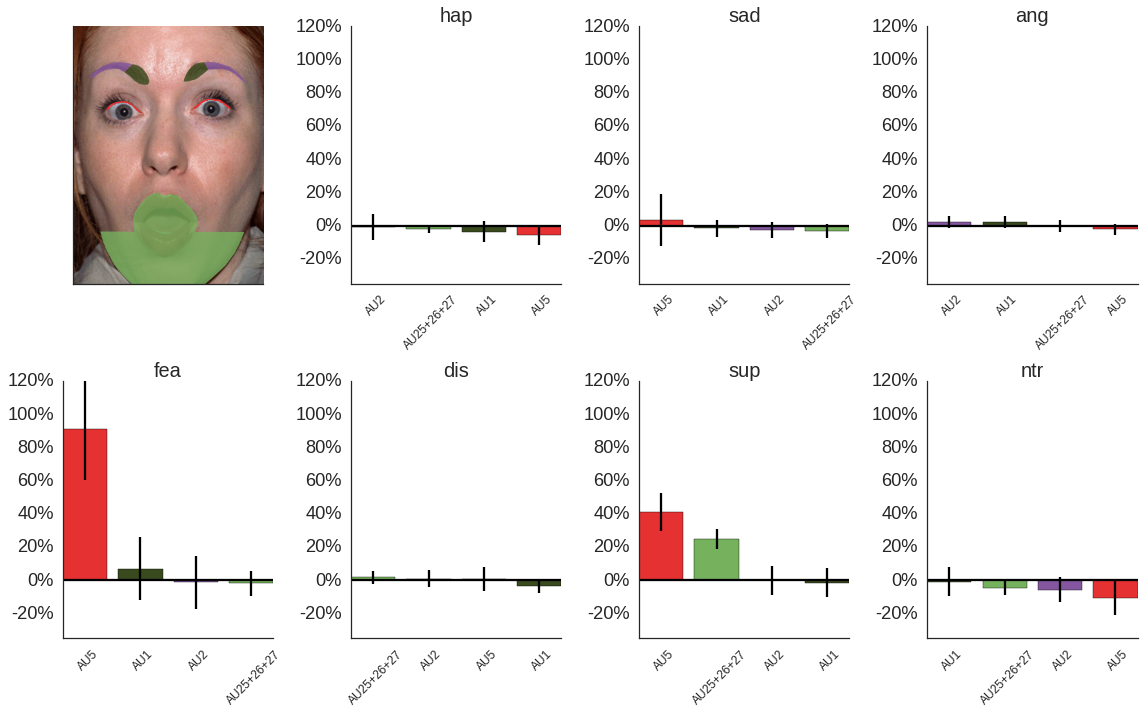

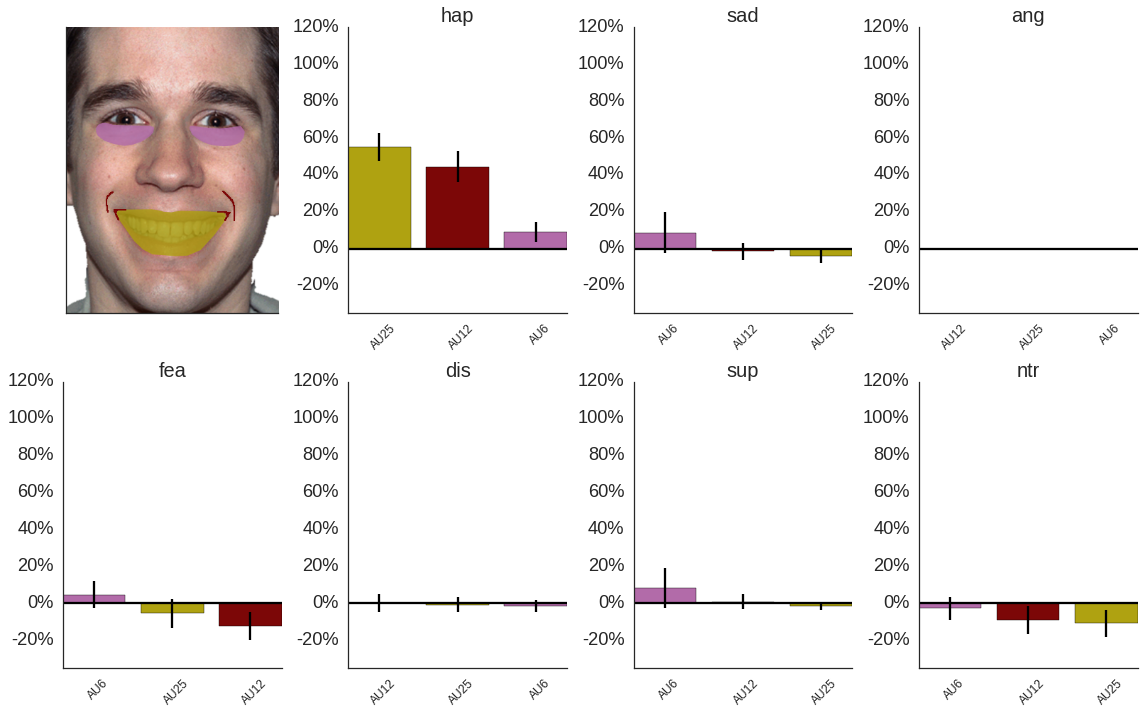

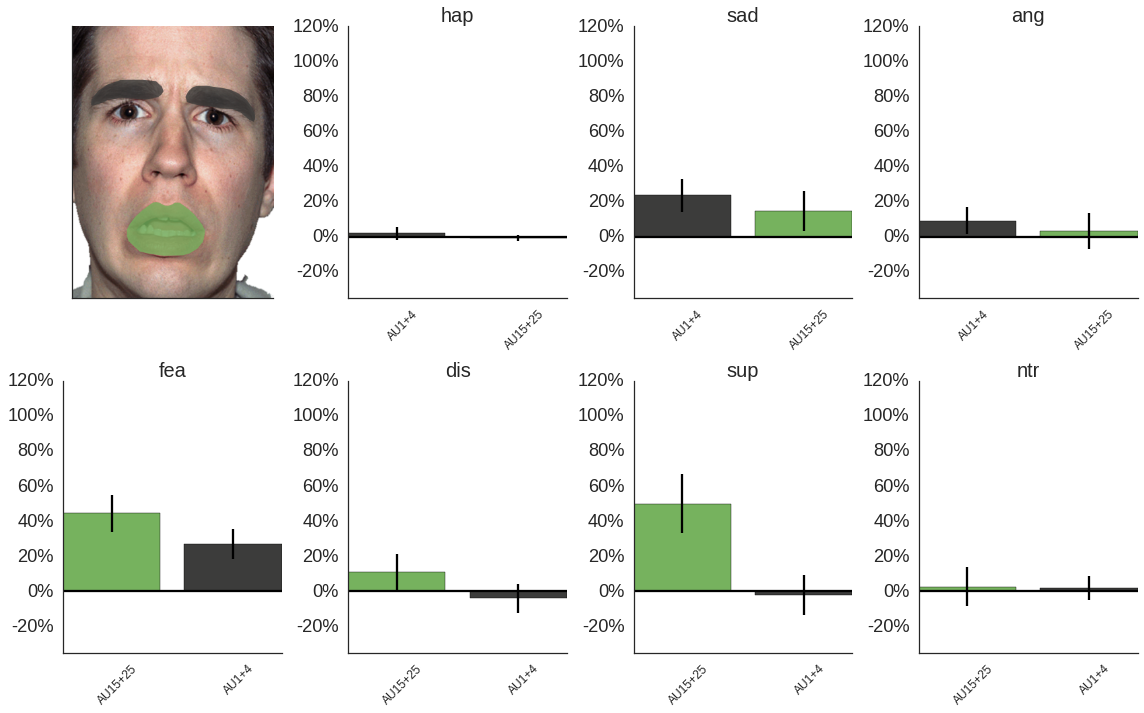

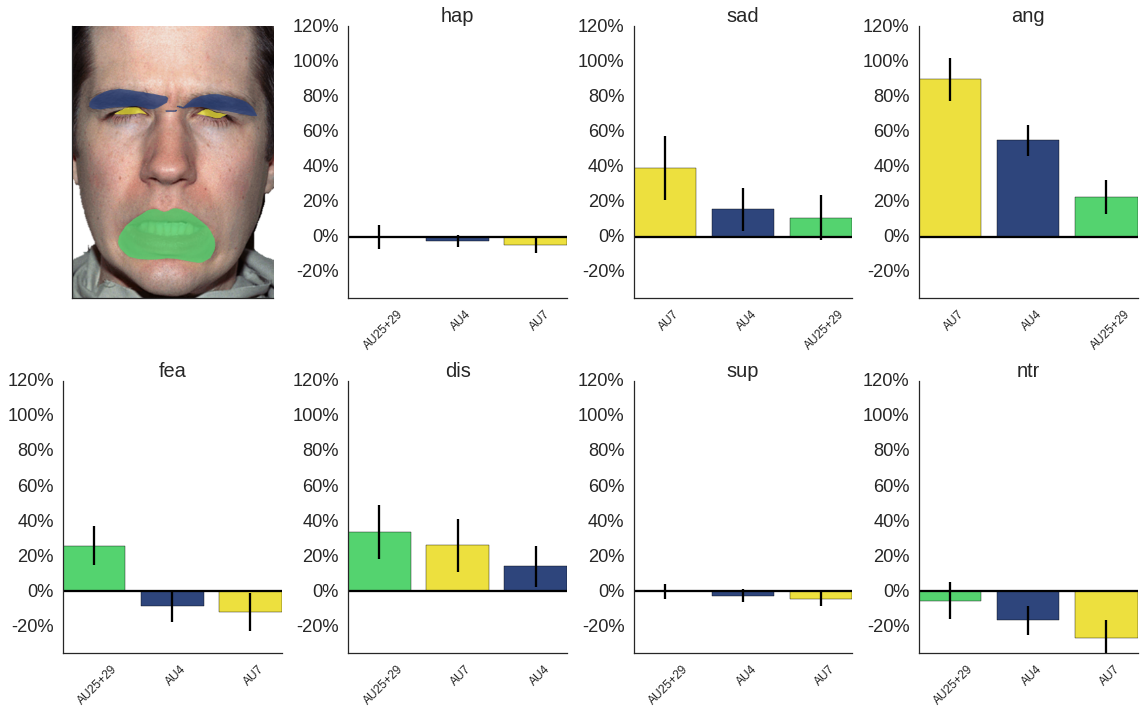

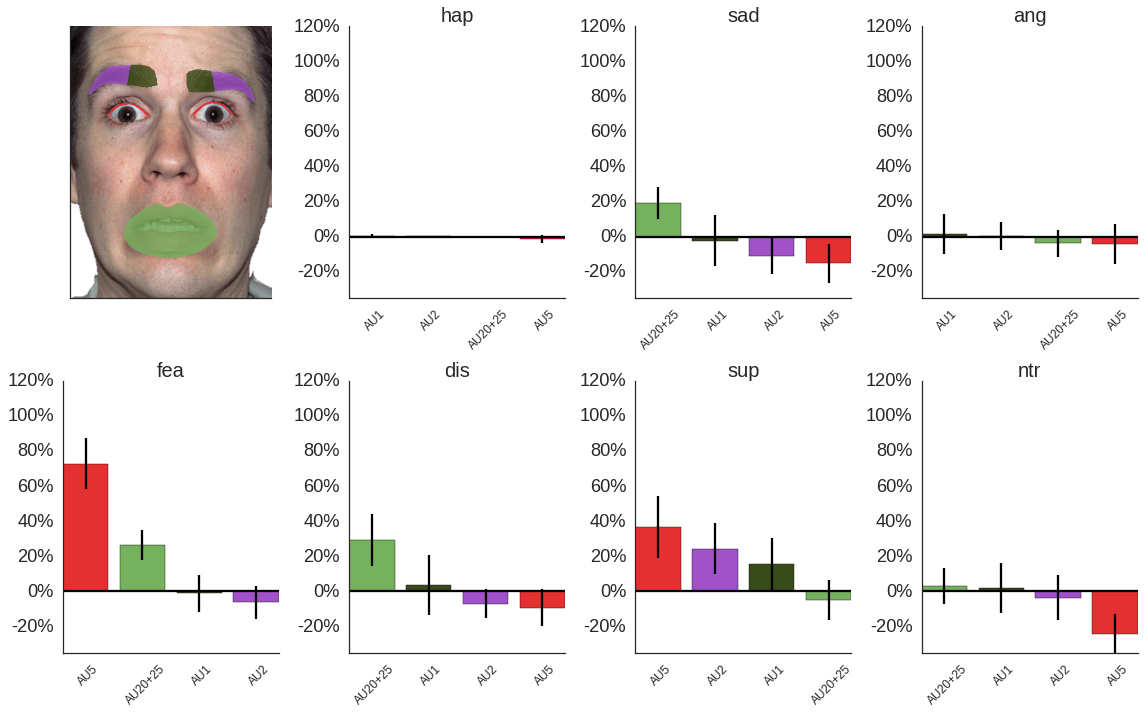

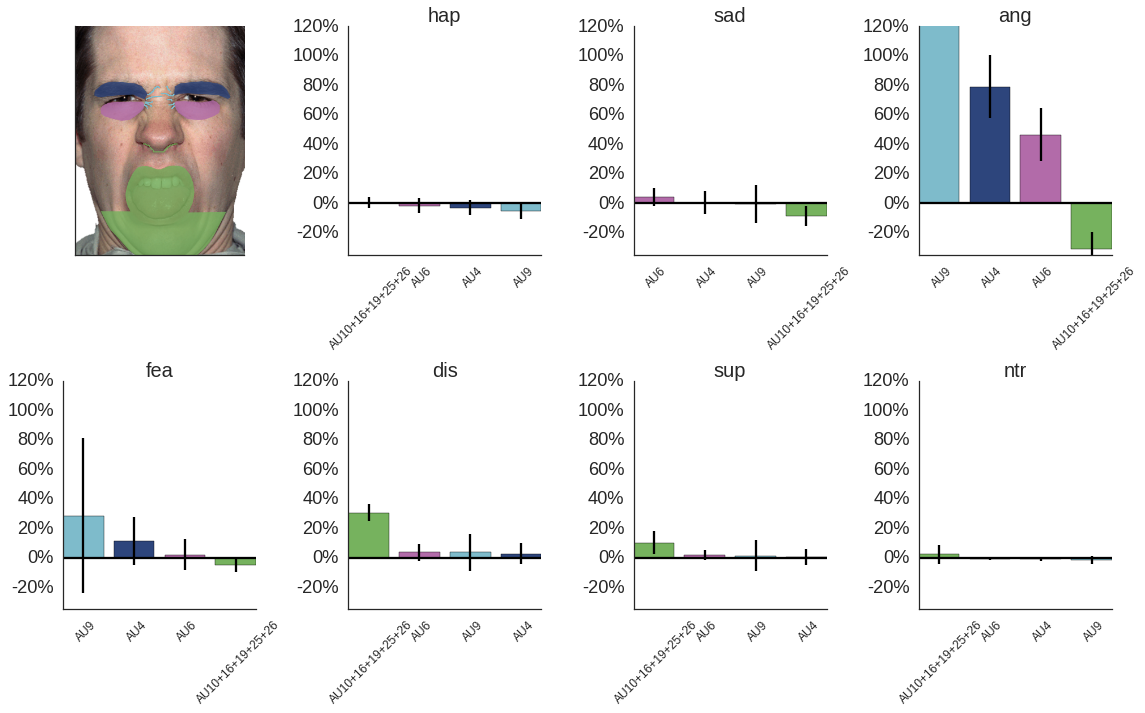

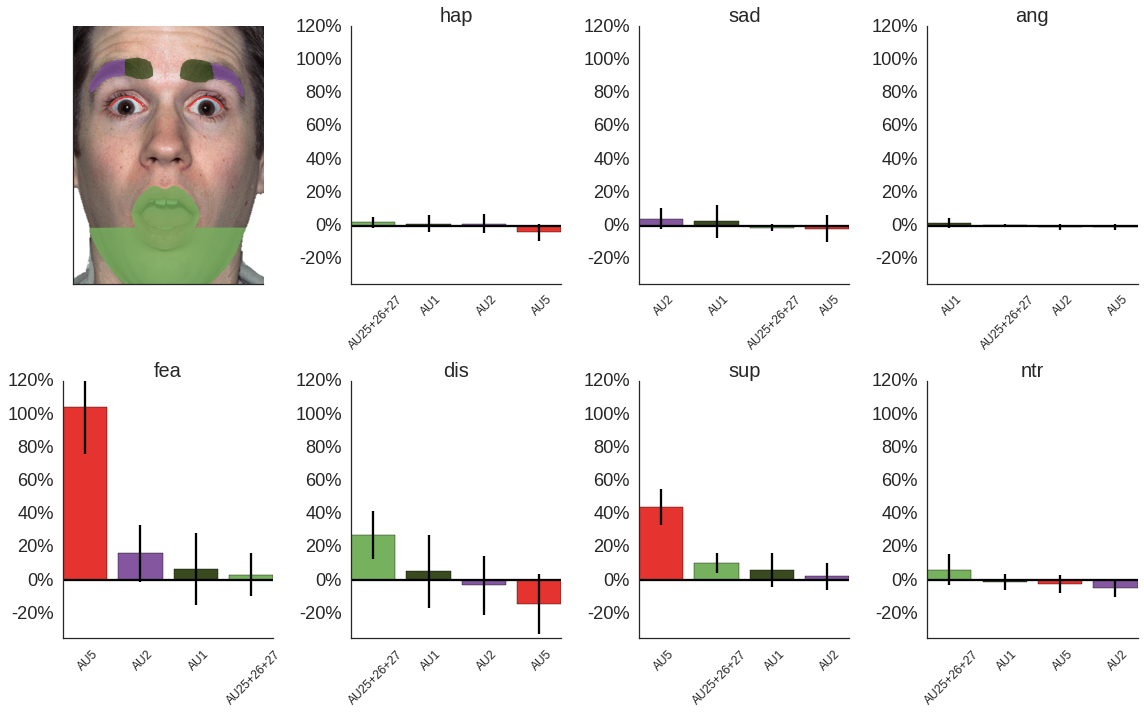

In [50]:
for i in ['f','m']:
    for e in ['hap','sad','ang','fea','dis','sup']:
        makePlot(i,e);

get a list of all saved files

In [51]:
auPics = getFile('../auConfusions/','confPlot*.png')

### Make an interactive plot

In [52]:
# Interactive plots for static html notebooks; using ipywidgets by Jake Vanderplas  
# https://github.com/jakevdp/ipywidgets-static

from ipywidgets_static import StaticInteract, RangeWidget, RadioWidget

Define function for interactive plot

In [53]:
def iPlot(i,e):
    fig = plt.figure(figsize=(20, 12))
    im = Image.open('../auConfusions/confPlot_'+i+'_'+e+'.png')
    plt.imshow(im)
    sns.despine(left=True,bottom=True)
    plt.xticks([]);plt.yticks([])
    return fig

Show interactive plot

In [54]:
StaticInteract(iPlot,
               i=RadioWidget(['f','m']),
               e=RadioWidget(['hap','sad','ang','fea','dis','sup'])
              )